https://github.com/MeepMoop/tilecoding/tree/master

If state space is huge, we want to approximate $v_\pi(s)$ with a function $\hat v(s,\vec{w})$ that can generalize.

$\vec{w} \in \R^d$ is a vector that holds parameters of $\hat v(s,\vec{w})$ and we assume that $ d \ll |S|$. 

Downside of this generalization is that if function generalizes $S_i$ and $S_j$, by updating function value for $\hat v(s = S_i,\vec{w})$ will also affect output for other state

## _Value error_

For individual state $s$ we can write a value error, that shows how good is the approximation:
$$ve(s,\vec{w}) = v_\pi(s)-\hat v(s,\vec{w})$$
We could write an global Value error $\overline{VE}(\vec{w})$, which sums all state value errors (absolute values or powers of 2), but since states are coupled via generalization, we should assign importance for more common states:

$$\overline{VE}(\vec{w}) = \sum_{s \in S} \mu(s)\cdot ve(s,\vec{w})^2 = \sum_{s \in S} \mu(s)\bigg[v_\pi(s)-\hat v(s,\vec{w})\bigg]^2$$

where $\mu(s)$ , for example, is a distribution of time spend on each state $s$


## Stochastic Gradient Descent (SGD)

Gradient of a function $f(\vec{w}):\nabla_{\vec{w}} f(\vec{w})$ shows direction in space of $\vec{w}$ which increases $f(\vec{w})$ the most. 

Conversely, reversed gradient $-\nabla_{\vec{w}} f(\vec{w})$ shows direction of reduction of $f(\vec{w})$

Optimization of $\hat v(s,\vec{w})$, with a goal of better approximation, can be done via gradient descent (GD) by minimizing $\overline{VE}(\vec{w})$.

Particularly this is done by introducing new data into optimization and by it improving current version of weights $\vec{w}_t$ to a better set of weights $\vec{w}_{t+1}$. 

Classic GD updates weights by solving optimization step for all states ${s \in S}$ simultaneously.
$$\vec{w}_{t+1} = \vec{w}_{t} - \alpha \cdot \nabla_{\vec{w}}\big[\overline{VE}(\vec{w}) \big]$$
If we perform this process incrementally for individual state $S_t$ this process is called Stochastic Gradient Descent -  SGD.
$$\vec{w}_{t+1} = \vec{w}_{t} - \alpha \cdot \nabla_{\vec{w}_t} \big[ve(S_t,\vec{w}_t)^2 \big] $$

where $\alpha$ is "step size" or "learning rate". Since we know that value error is quadratic, we can pick a convenient value of $\frac{\alpha}{2}$ for the following chain rule:

$$\vec{w}_{t+1} = \vec{w}_{t} - \frac{1}{2} \alpha\nabla_{\vec{w}_t}\bigg[v_\pi(S_t)-\hat v(S_t,\vec{w}_t)\bigg]^2=$$
$$ = \vec{w}_{t} + \alpha \cdot \bigg[v_\pi(S_t)-\hat v(S_t,\vec{w}_t)\bigg]\cdot \nabla_{\vec{w}_t} \hat v(S_t,\vec{w}_t)$$

Small step/learning rate is necessary since we are observing only a subset of states, which do not represent function globally - fully fixing error on one step/state does not fix other states

We also dont know true value of $v_\pi(s)$, only an estimate. Lets call it $U_t$, so:
$$\boxed{\vec{w}_{t+1} = \vec{w}_{t} + \alpha \cdot \bigg[U_t - \hat v(S_t,\vec{w})\bigg]\cdot \nabla_{\vec{w}_t} \hat v(S_t,\vec{w}_t)}$$

Monte Carlo (MC) method estimates true expected discounted reward $U_t = G_t$ and is expected to converge to local optimum:
$$ \vec{w} \leftarrow \vec{w} = \alpha \big[ \underbrace{G_t}_{\text{target}}- \hat v(S,\vec{w}) \big] \cdot \nabla_{\vec{w}_t} \hat v(S,\vec{w})$$

Bootstrapping methods (TD or DP) have target value rewards that are are biased with respect to $\vec{w}_t$:
$$ \text{[TD(0) example]: } \vec{w} \leftarrow \vec{w} = \alpha \big[ \underbrace{R + \gamma \hat v(S^\prime,\vec{w})}_{\text{target}}- \hat v(S,\vec{w}) \big] \cdot \nabla_{\vec{w}_t} \hat v(S,\vec{w})$$
which makes then only 'semi-gradient methods' and they have no convergence guarantees. But in practice they still converge with linear cases. It is important since ability to work online is very beneficial. 

## Linear Methods
$\hat v(\cdot, \vec{w})$ is a linear combination of basis functions $\vec{x}(s) = \{x_1(s), x_2(s),\dots\}^T$
$$\hat v(s, \vec{w}) = \vec{w}^T \vec{x}(s) = \sum_{i = 1}^d w_i x_i(s)$$ 
Gradient is:
$$\nabla_{\vec{w}} \hat v(s, \vec{w}) = \vec{x}(s) $$

so SGD update is

$$\boxed{\vec{w}_{t+1} = \vec{w}_{t} + \alpha \cdot \bigg[U_t - \hat v(S_t,\vec{w})\bigg]\cdot \vec{x}(S_t) }$$

For TD(0) method under linear approximation:

$$\vec{w}_{t+1} = \vec{w}_t + \alpha \big[ \underbrace{R_{t+1} + \gamma \hat v(S_{t+1}, \vec{w}_t) }_{\text{target}}- \hat v(S_t,\vec{w}_t) \big] \cdot \vec{x}(S_t) = $$
$$= \vec{w}_t + \alpha \big[R_{t+1} + \gamma \vec{w}_t^T \vec{x}(S_{t+1})  - \vec{w}_t^T \vec{x}(S_t) \big] \cdot \vec{x}(S_t) = $$
$$= \vec{w}_t + \alpha \big[R_{t+1} + \gamma \vec{w}_t^T \vec{x}_{t+1}  - \vec{w}_t^T \vec{x}_t \big] \cdot \vec{x}_t = $$
$$ = 
\vec{w}_t + \alpha \big[R_{t+1}\vec{x}_t -\vec{x}_t(\vec{x}_t- \gamma \vec{x}_{t+1})^T \vec{w}_t $$

When $\vec{w}$ has reached steady state (convergence)
$$\mathbb{E}[\vec{w}_{t+1}|\vec{w}_t] = \vec{w}_t  + \alpha \bigg[ \mathbb{E}[R_{t+1} \vec{x}_t] - \mathbb{E}[\vec{x}_t(\vec{x}_t- \gamma \vec{x}_{t+1})^T]) \bigg] =$$
$$ =  \vec{w}_t + \alpha (\vec{b}- A \vec{w}_t)$$
which converged to $\vec{w}_{TD}$
$$\vec{w}_{TD} = \vec{w}_{TD}   + \alpha (\vec{b}- A \vec{w}_{TD}) \rightarrow$$
$$\vec{0} = \vec{b}- A \vec{w}_{TD}\rightarrow$$
$$ \vec{w}_{TD} = A^{-1}\vec{b}$$
which is a TD _fixed point_. This point is within a certain radius of global minimum. Radius reduces as $\frac{1}{1-\gamma}$

## Polynomials
each state -> k numbers: $\{s_1, s_2,\dots, s_k\}$
for k-dimensional state space, each order $n$ poly can be written as:
$$x_i(s) = \Pi_{k=1}^k s_j^{c_{i,j}}$$
$$c_{i,j} = \{0,1,\dots, n\}$$
i.e
$$k = 2; \ S \rightarrow \{s_1,s_2\}; \ c = 2$$

$$\vec{x} = \{1,s_1,s_2,s_1s_2,s_1^2,s_2^2,s_1s_2^2,s_1^2s_2,s_1^2s_2^2\}$$
$$x_0(s) = 1 = s_1^0s_2^0 \rightarrow c_1 = \{0,0\}$$
$$x_1(s) = s_1 = s_1^1s_2^0 \rightarrow c_2 = \{1,0\}$$
$$\dots$$
$$x_8(s) = s_1^2s_2 = s_1^2s_2^1 \rightarrow c_8 = \{2,1\}$$
$$x_9(s) = s_1^2s_2^2 = s_1^2s_2^1 \rightarrow c_9 = \{2,2\}$$

Cross terms $s_i^a s_j^b$ allows capture state 'interaction'

## Fourier Basis

$$\vec{s} = \{s_1,s_2,\dots, s_k\}^T; s_i \in [0,1]$$
$$x_i(s) = cos(\pi \vec{s}^T \vec{c}^i)$$
$$\vec{c}^i = \{c_1^i,\dots, c_k^i\}^T; \ c_j^i \in \{0,\dots,n\}$$

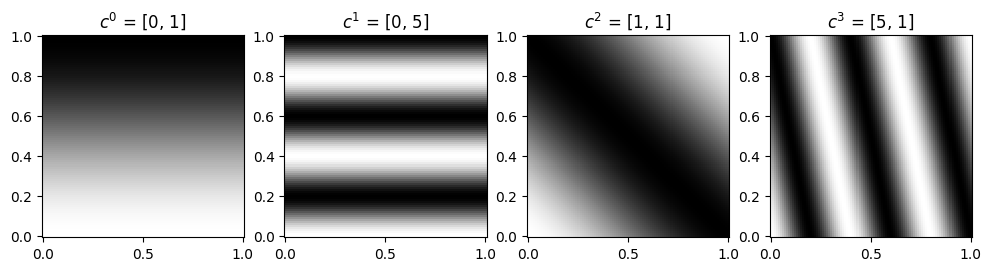

In [1]:
import matplotlib.pyplot as plt
import numpy as np

cs = [[0,1],[0,5],[1,1],[5,1]]

def x(s1, s2, c):
    a,b = c
    return np.cos(np.pi * (a* s1 + b* s2))

N = 100
S1,S2 = np.meshgrid(np.linspace(0,1,N),np.linspace(0,1,N))

fig, axs = plt.subplots(1,4, figsize = (12,3))
axs = axs.flatten()

for i,a in enumerate(axs):
    a.pcolormesh(S1,S2,x(S1,S2,cs[i]),cmap='gray')
    a.set_title('$c^'+ str(i)+ '$ = '+ f'{cs[i]}')
    a.set_aspect(1)

## Coarse Coding
Binary features. 

Space is divided in overlapping regions points can be 'present' in multiple neighboring regions, which is one-hot encoded. This allows to keep information about proximity of states (generalization). But it cannot differentiate between states that are too close.

In [5]:
def square_wave(x):
    if x < 1/3  or x > 2/3 : return 0
    else: return 1

In [3]:
num_segments = 50
overlap = 6.0
seg_len = 1 / num_segments
start_end = []
for i in range(num_segments):
    start_end.append([i*seg_len,(i+1)*seg_len])

start_end = np.array(start_end)
start_end += [[-overlap*seg_len,overlap*seg_len]]
np.clip(start_end,0,1, out=start_end)

def within(x):
    return (x >= start_end[:,0]) & (x < start_end[:,1])

$$\boxed{\vec{w}_{t+1} = \vec{w}_{t} + \alpha \cdot \bigg[U_t - \hat v(S_t,\vec{w})\bigg]\cdot \vec{x}(S_t) }$$
$$\hat v(s, \vec{w}) = \vec{w}^T \vec{x}(s) = \sum_{i = 1}^d w_i x_i(s)$$ 

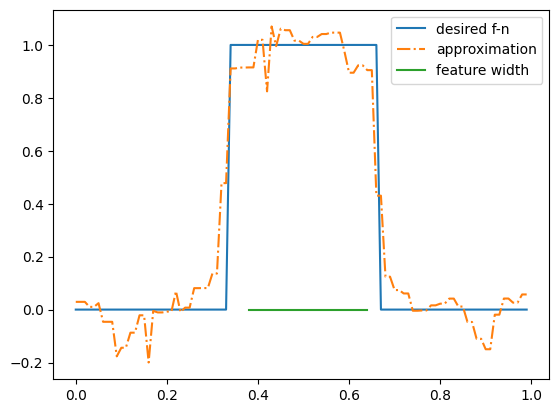

In [16]:

w = np.zeros(shape= (num_segments,))

def model(x, w):
    encoding = within(x)
    return np.dot(w, encoding)

for _ in range(10600):
    s_test      = np.random.random()
    sol_model   = model(s_test, w)
    sol_true    = square_wave(s_test)
    x_i         = within(s_test)
    alpha       = 0.2 / x_i.sum()
    w += alpha * (sol_true - sol_model) * x_i

p_dom = np.arange(0,1,0.01)
#square_wave = np.vectorize(square_wave)
plt.plot(p_dom,[square_wave(a)  for a in p_dom] , label = 'desired f-n'  );
plt.plot(p_dom,[model(s, w)     for s in p_dom] , label = 'approximation', ls='-.');
plt.plot(start_end[num_segments//2], [0,0]      , label = 'feature width');
plt.legend()
plt.show()

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from misc_tools.print_latex import print_tex

input example : 
>>> arr_T = np.array([[r'\vec{v}_1', r'\vec{v}_2']]).T
>>> print_tex(arr_T,'=', np.arange(1,5).reshape(2,-1)/4, r'; symbols: \otimes, \cdot,\times')
output: 


<IPython.core.display.Math object>

My implementation is such that i create an expanded matrix (big red) which holds all tiles/layers and cut out working matrix/index domain

my definitions:
*   tile/layer = grid of smaller tiles (segments), third dimension of a matrix (technically i store on a first axis)
*   sub-tile/segment, each tile is divided into NxN segments

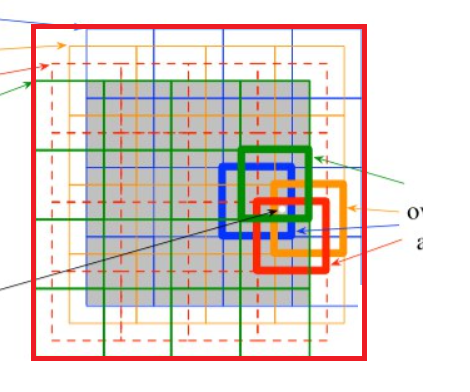

*   I fill sectors/sub-tiles with unique IDs while shifting starting position on each tile/layer

*   Overlap:

    *   it is not manual but controlled via number of tiles/layers
    *   i want each entry in domain to give (# tiles) = active tiles : each segment is sampled from domain.
    *   indices are quantized, so number of indices per sector is an integer
        *   2 layers/tiles = 0.5 sub-tile/segment overlap. its ok for any segment side size divisible by 2
        *   for more layers = less overlap, we should increase segment side size (index count)
        *   minimal overlap can be 1 index
        
*   then i make a linear map from problem domain to indices domain

*   create intermediate embeddings matrix for indices, M_emb[x,y] = one-hot-encoded vector

*   create mapping from domain (x,y) to one-hot embeddings = problem-index map->retrieve embedding

In [171]:
def generate_tiles(number_of_sectors,number_of_indices_per_sector,number_of_tiles):
    N_SECTORS       = number_of_sectors             # num sectors on the side
    N_PER_SECTOR    = number_of_indices_per_sector  # indices on a sector side
    N_TILES         = number_of_tiles               # number of tiles/layers
    N_ENTRIES = N_SECTORS * N_PER_SECTOR            # total entries on a side. before overlap calc
    assert N_PER_SECTOR / N_TILES >= 1, 'overlap smaller than 1 index'
    OVERLAP = N_PER_SECTOR // N_TILES               # is such that each sector is in domain

    N_ENTRIES_INT_EXT = N_ENTRIES + (N_TILES-1)*OVERLAP # expand side (# of indices) of big matrix
    #print(OVERLAP,N_ENTRIES,N_ENTRIES_INT_EXT)
    M_mini = np.arange(N_SECTORS*N_SECTORS*N_TILES).reshape(N_TILES,N_SECTORS,N_SECTORS) # sub-tiles IDs
    #print_tex(*[M_mini[i] for i in range(len(M_mini))])
    M = np.zeros(shape=(N_TILES, N_ENTRIES_INT_EXT,N_ENTRIES_INT_EXT), dtype=int)
    for index, ID in np.ndenumerate(M_mini):    # fill big matrix M with sub-tiles based on mini M
        tile_ID, x,y = index
        slice_x = slice(x*N_PER_SECTOR + tile_ID*OVERLAP,(x+1)*N_PER_SECTOR + tile_ID*OVERLAP)
        slice_y = slice(y*N_PER_SECTOR + tile_ID*OVERLAP,(y+1)*N_PER_SECTOR + tile_ID*OVERLAP)
        M[tile_ID,slice_x,slice_y] = ID

    #print_tex(*[M[i] for i in range(len(M))])
    
    st = (N_TILES-1)*OVERLAP                    # keep only useful overlaps
    M_sub = M[:,st:N_SECTORS*N_PER_SECTOR,st:N_SECTORS*N_PER_SECTOR]
    #print_tex(*[M_sub[i] for i in range(len(M_sub))])
    return M_sub, M_mini

M, M_mini = generate_tiles(number_of_sectors = 20,number_of_indices_per_sector = 10, number_of_tiles = 5)
#print_tex(*[M[i] for i in range(len(M))])

DOMAIN_X_MIN,DOMAIN_X_MAX = (0.0, 2.0 * np.pi)# -1,1
DOMAIN_Y_MIN,DOMAIN_Y_MAX = (0.0, 2.0 * np.pi)# -2.3,0.3

Mxmax, Mymax = np.array(M[0].shape) - 1

# y = k*x + m
k0 = (Mxmax - 0)/(DOMAIN_X_MAX - DOMAIN_X_MIN)
k1 = (Mymax - 0)/(DOMAIN_Y_MAX - DOMAIN_Y_MIN)
m0 = -k0*DOMAIN_X_MIN
m1 = -k1*DOMAIN_Y_MIN

def xmap(x):
    return int(k0*x + m0)

def ymap(y):
    return int(k1*y + m1)

M_embed = np.zeros(shape=(*M[0].shape, M_mini.size), dtype=int)    # last dim = embedding

for (x, y), _ in np.ndenumerate(M[0]):
    where_ones = M[:,x,y]           # slice across tiles dim
    M_embed[x,y][where_ones] = 1    # one-hot encode

def get_embed(x,y):
    # map domain to matrix indices
    id_x, id_y = xmap(x),ymap(y)
    return M_embed[id_x,id_y]

#xmap(DOMAIN_X_MIN),xmap(DOMAIN_X_MAX), ymap(DOMAIN_Y_MIN),ymap(DOMAIN_Y_MAX), get_embed(DOMAIN_X_MIN,DOMAIN_Y_MIN)


copy parts from https://github.com/MeepMoop/tilecoding/tree/master.

author there stores active tile IDs, so he subsets w[active_tiles] += delta

i keep one-hot/binary mask, so i mask delta with active_tiles-> w += delta*active_tiles
, which is more consistent with theory

$$\boxed{\vec{w}_{t+1} = \vec{w}_{t} + \alpha \cdot \bigg[U_t - \hat v(S_t,\vec{w})\bigg]\cdot \vec{x}(S_t) }$$

In [194]:
def target_fn_noisy(x, y):
  return np.sin(x) + np.cos(y) + 0.1 * np.random.randn()

def target_fn(x, y):
  return np.sin(x) + np.cos(y)

w = np.zeros(M_mini.size)

# step size for SGD
alpha = 0.2/3

# learn from 10,000 samples
for i in range(10000):
   # get noisy sample from target function at random location
  x, y = 2.0 * np.pi * np.random.rand(2)
  target = target_fn_noisy(x, y)
  # get prediction from active tiles at that location
  active_tiles = get_embed(x,y)
  pred = np.dot(w, active_tiles)
  # update weights with SGD
  w += alpha * (target - pred)*active_tiles



x, y = 2.0 * np.pi * np.random.rand(2)
target_fn(x, y), np.dot(w, get_embed(x,y))


(1.2278522225425499, 1.2638131235900798)

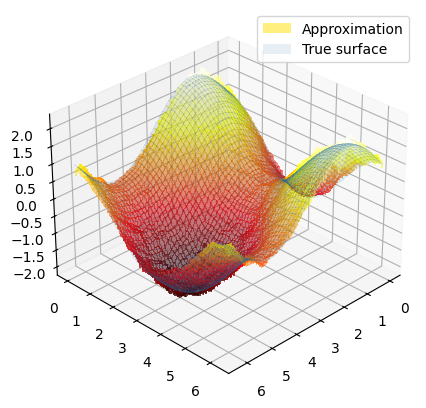

0.04911357888569453

In [196]:
res = 400

x = np.arange(0.0, 2.0 * np.pi, 2.0 * np.pi / res)
y = np.arange(0.0, 2.0 * np.pi, 2.0 * np.pi / res)

z = np.zeros([len(x), len(y)])
for i in range(len(x)):
  for j in range(len(y)):
    z[j,i] = np.dot(w, get_embed(x[i], y[j]))
    
# fig, ax = plt.subplots(1,2,subplot_kw={"projection": "3d"})
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1, 1, 1, projection='3d')
X, Y = np.meshgrid(x, y)
surf = ax.plot_surface(X, Y, z, cmap=plt.get_cmap('hot'), linewidth=0, antialiased=False, alpha = 0.5, label='Approximation')
Z = target_fn(X,Y)
ax.plot_surface(X, Y, Z, linewidth=1, antialiased=False, alpha = 0.1, label='True surface')
ax.view_init(elev=30., azim=45)
plt.legend()
# ax = fig.add_subplot(1, 2, 2)
# ax.matshow(M[0])
plt.show()

np.abs(Z-z).flatten().mean()